# BitTrack Project
## Send request and Get data

In [1]:
import requests
import csv
import json

import datetime
import time
import pandas as pd
import matplotlib.pyplot as plot
import numpy as np

month = 2629743
# hour = 3600
now = int(time.time())
start_time = now - 3*month
DATALENGTH = 200
ema_length = 50

url = f"http://api.coincap.io/v2/assets/bitcoin/history?interval=h1"
print(url)

payload = {}
headers= {}
response = requests.request("GET", url, headers=headers, data=payload)
json_data = json.loads(response.text.encode('utf8'))
# print(json_data)
bitcoin_data = json_data["data"]

df = pd.DataFrame(bitcoin_data)
df.to_csv('bitcoin-usd.csv', index=False)
print(df.sample)
# df.dtypes

df = pd.DataFrame(bitcoin_data, columns=['time', 'priceUsd'])
# Get last 200 rows and REVERSE, newest price on top (index 0)
df = df[:-DATALENGTH-1:-1]
print(df.sample)

# Convert datatype of priceUsd
df['priceUsd'] = pd.to_numeric(df['priceUsd'], errors='coerce', downcast='integer').fillna(0, downcast='infer')
df.dtypes
df.info()


http://api.coincap.io/v2/assets/bitcoin/history?interval=h1
<bound method NDFrame.sample of                    priceUsd           time          circulatingSupply  \
0    34236.9594235070096403  1623222000000  18730687.0000000000000000   
1    34218.1735338182528081  1623225600000  18730687.0000000000000000   
2    34004.6707341562287244  1623229200000  18730687.0000000000000000   
3    34110.1887097105584451  1623232800000  18730818.0000000000000000   
4    34512.3364777292157392  1623236400000  18730818.0000000000000000   
..                      ...            ...                        ...   
715  32641.5770169815967503  1625796000000  18743737.0000000000000000   
716  32959.1584615310515164  1625799600000  18743737.0000000000000000   
717  32941.9179684421820739  1625803200000  18743737.0000000000000000   
718  33036.3647401486107611  1625806800000  18743737.0000000000000000   
719  32999.6946018323565820  1625810400000  18743737.0000000000000000   

                         date  

In [2]:
# Check data 
prices = df['priceUsd']
print(prices)

719    32999.694602
718    33036.364740
717    32941.917968
716    32959.158462
715    32641.577017
           ...     
524    34487.888665
523    34898.422875
522    34779.466801
521    34941.509099
520    34802.526488
Name: priceUsd, Length: 200, dtype: float64


In [3]:
# Calculate and check last ema value 
count = 0
def ema(prices, count, length = ema_length, smoothing = 2):
    multiplier = smoothing/(1+length)
    if count < length:
        # print(prices.iloc[count])
        price = (prices.iloc[count] * multiplier) 
        count += 1
        return price + ema(prices, count ) * (1 - multiplier)
    return prices.iloc[count]

In [4]:
print("EMA50 H1:", ema(df['priceUsd'], count))

EMA50 H1: 33350.17936775134


In [5]:
# Process UNIX time to readable form
timeStamp =  df['time'].values.tolist()
timeStamp = [x / 1000 for x in timeStamp]

In [6]:
# Insert readable timeStamp column to 'df'
df['timeStamp'] = pd.to_datetime(timeStamp, unit='s')

In [7]:
# Check
df.sample

<bound method NDFrame.sample of               time      priceUsd           timeStamp
719  1625810400000  32999.694602 2021-07-09 06:00:00
718  1625806800000  33036.364740 2021-07-09 05:00:00
717  1625803200000  32941.917968 2021-07-09 04:00:00
716  1625799600000  32959.158462 2021-07-09 03:00:00
715  1625796000000  32641.577017 2021-07-09 02:00:00
..             ...           ...                 ...
524  1625108400000  34487.888665 2021-07-01 03:00:00
523  1625104800000  34898.422875 2021-07-01 02:00:00
522  1625101200000  34779.466801 2021-07-01 01:00:00
521  1625097600000  34941.509099 2021-07-01 00:00:00
520  1625094000000  34802.526488 2021-06-30 23:00:00

[200 rows x 3 columns]>

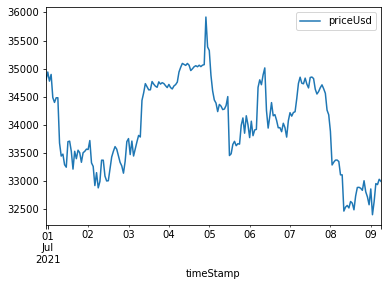

In [8]:
# Plot the data
df.plot(x ='timeStamp', y='priceUsd', kind = 'line')
plot.show()

## Calculate the possible EMA for each timeStamp
'possible' means timeStamp that have at lease 50 values before it. After that, we add EMA value along with the above figure.

In [9]:
short_df = df.head(DATALENGTH-ema_length)
short_df.reset_index()

,index,time,priceUsd,timeStamp
0,719,1625810400000,32999.694602,2021-07-09 06:00:00
1,718,1625806800000,33036.364740,2021-07-09 05:00:00
2,717,1625803200000,32941.917968,2021-07-09 04:00:00
3,716,1625799600000,32959.158462,2021-07-09 03:00:00
4,715,1625796000000,32641.577017,2021-07-09 02:00:00
...,...,...,...,...
145,574,1625288400000,33700.326035,2021-07-03 05:00:00
146,573,1625284800000,33576.630649,2021-07-03 04:00:00
147,572,1625281200000,33449.414512,2021-07-03 03:00:00
148,571,1625277600000,33714.760299,2021-07-03 02:00:00


In [10]:
short_df['EMA'] = np.zeros(( DATALENGTH-ema_length, 1))

<ipython-input-10-b2c0fb1e9939>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_df['EMA'] = np.zeros(( DATALENGTH-ema_length, 1))


In [11]:
# short_df['N'] = np.arange(len(short_df))
short_df.insert(loc=0, column='N', value=np.arange(len(short_df)))

In [12]:
# Access the last value of row EMA
short_df.loc[713,'EMA'] = 999999

# short_df.isetter
print(short_df['EMA'].iloc[-1])

0.0
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [13]:
def ema(prices, count, length = ema_length, smoothing = 2):
    multiplier = smoothing/(1+length)
    if count < length:
        # print(prices.iloc[count])
        price = (prices.iloc[count] * multiplier) 
        count += 1
        return price + ema(prices, count ) * (1 - multiplier)
    return prices.iloc[count]

for i in range(0, DATALENGTH-ema_length):
    count = 0
    short_df.iloc[i,4] = ema(df['priceUsd'].iloc[i:], count)


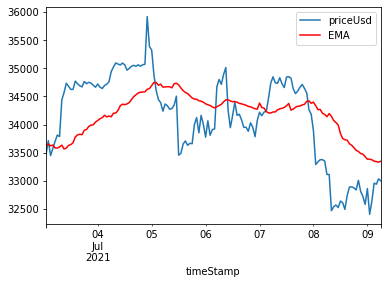

In [14]:
# https://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot
ax = plot.gca()
short_df.plot(kind='line',x='timeStamp',y='priceUsd', ax=ax)
short_df.plot(kind='line',x='timeStamp',y='EMA', color='red', ax=ax)
plot.show()